<a href="https://colab.research.google.com/github/udaykiranreddykondreddy/Code-for-learn-machinelearning/blob/master/hyperparameter_tuning/bayesian_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://drive.google.com/uc?export=view&id=1xZggtEjnrMp9QBm_4q5RJIfJyfSoSJ9p" height="150" align="left"/>
<h1>&nbsp;<a href="https://instagram.com/learn.machinelearning">Learn.MachineLearning</a></h1>
<h2>&nbsp;Hyperparameter tuning</h2>
<h2>&nbsp;Bayesian Search</h2>

In [0]:

from hyperopt import tpe
from hyperopt import STATUS_OK
from hyperopt import Trials
from hyperopt import hp
from hyperopt import fmin

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

MAX_EVALS = 50

<img src="http://drive.google.com/uc?export=view&id=1oU4iFcgqdhLTgDcTHMysKIYaIxMfgu50" height="200"/>

<img src="http://drive.google.com/uc?export=view&id=1OJoCNZoNNI58MW0PU96AoPNNgT5ay6mo" height="300"/>

<img src="http://drive.google.com/uc?export=view&id=1AqWmYGEKzFMSyr9uithhpEd3Ks4MbaKL" height="300"/>


**Problems of Grid and Random search**
- Each new guess is independent of the previous run.
- The problem is that it doesn’t guarantee to give the best parameters combination.

**<h2> Bayesian Search </h2>**
- Goal is to reduce the no of trails
- Bayesian Optimization
- keep track of past evaluation results
- Builds the probabilistic model of objective function called surrogate
- spends more time in choosing the next values

**p(Score|Hyperparameters)**

**Surrogate methods**
- Gaussian Processes [spearmint](https://github.com/JasperSnoek/spearmint) and [MOE](https://github.com/Yelp/MOE)
- Random Forest Regression [SMAC](https://github.com/automl/SMAC3)
- Tree Parzen Estimator (TPE). [Hyperopt](https://github.com/jaberg/hyperopt)

**p(Score|Hyperparameters) = (p(Score|Hyperparameters) * p(Score)) / p(Hyperparameters)**

**selection function**
- Expected Improvment



**```
Steps
```**
- Build the surrogate probability model of the objective function
- Find hyperparameters that work best on surrogate models.
- try these on real objective function
- update the surrogate model incorporating the new results
- repeat 2-4 steps.

**Hyperopt**
- Objective Function
- Domain space (Probability distributions)
- Optimization Algorithm
- Results

In [89]:
# load the dataset

# you can find the dataset here https://www.kaggle.com/mlg-ulb/creditcardfraud
from google.colab import files
uploaded = files.upload()
#

Saving kaggle.json to kaggle (1).json


In [0]:
# #Run this to create a kaggle environment
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
# Get data from kaggle 
import zipfile
# Download data
!kaggle datasets download -d mlg-ulb/creditcardfraud
# UnZip data

zip_ref = zipfile.ZipFile("creditcardfraud.zip", 'r')
zip_ref.extractall()
zip_ref.close()

 86% 57.0M/66.0M [00:01<00:00, 28.6MB/s]
100% 66.0M/66.0M [00:01<00:00, 45.6MB/s]


In [0]:
!ls

creditcard.csv	creditcardfraud.zip  kaggle.json  sample_data


In [0]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


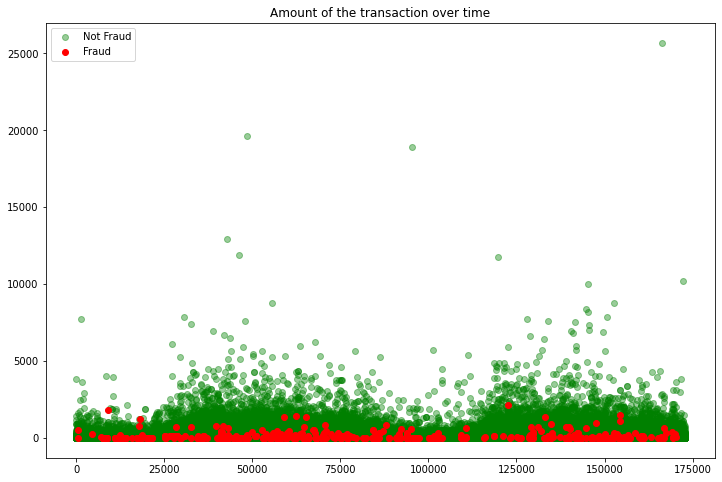

In [0]:
plt.figure(figsize=(12,8))
plt.scatter(df[df.Class == 0].Time, df[df.Class == 0].Amount, c='green', alpha=0.4, label="Not Fraud")
plt.scatter(df[df.Class == 1].Time, df[df.Class == 1].Amount, c='red', label="Fraud")
plt.title("Amount of the transaction over time")
plt.legend()
plt.show()

In [0]:
x_data, y_data = df.iloc[:,:-1], df["Class"]

In [0]:

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.30, random_state=35)

In [0]:
def objective(params, n_folds = N_FOLDS, X_train = X_train, y_train = y_train):

    clf = LogisticRegression(**params,random_state=0,verbose =0)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')

    # Extract the best score
    best_score = max(scores)

    # Loss must be minimized
    loss = 1 - best_score

    # Dictionary with information for evaluation
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

In [0]:
# Domain space for bayesian and random 
class_weight = {1: 0.0017, 0: 0}
space = {
    'class_weight': hp.choice('class_weight', [None, class_weight]),
    'warm_start' : hp.choice('warm_start', [True, False]),
    'fit_intercept' : hp.choice('fit_intercept', [True, False]),
    'tol' : hp.uniform('tol', 0.00001, 0.0001),
    'C' : hp.uniform('C', 0.05, 3),
    'solver' : hp.choice('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']),
    'max_iter' : hp.choice('max_iter', range(5,1000))
}


In [0]:
# Algorithm
tpe_algorithm = tpe.suggest

# Trials object to track progress
bayes_trials = Trials()

# Optimize
best = fmin(fn = objective, space = space, algo = tpe.suggest, max_evals = MAX_EVALS, trials = bayes_trials)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



  2%|▏         | 1/50 [02:49<2:18:41, 169.82s/it, best loss: 0.5004141566265061]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



  6%|▌         | 3/50 [03:11<1:09:27, 88.67s/it, best loss: 0.19213258071177797] 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



  8%|▊         | 4/50 [10:55<2:34:19, 201.29s/it, best loss: 0.19213258071177797]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 10%|█         | 5/50 [11:09<1:48:37, 144.83s/it, best loss: 0.19150306272490147]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 12%|█▏        | 6/50 [14:12<1:54:37, 156.31s/it, best loss: 0.19150306272490147]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 14%|█▍        | 7/50 [14:15<1:19:11, 110.49s/it, best loss: 0.19150306272490147]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 16%|█▌        | 8/50 [18:56<1:53:06, 161.59s/it, best loss: 0.19150306272490147]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 18%|█▊        | 9/50 [19:11<1:20:26, 117.73s/it, best loss: 0.13983427767567913]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 20%|██        | 10/50 [22:56<1:39:53, 149.83s/it, best loss: 0.13983427767567913]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 24%|██▍       | 12/50 [23:39<53:34, 84.58s/it, best loss: 0.1122322205718691]    

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did 

 26%|██▌       | 13/50 [24:58<51:08, 82.94s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coe

 28%|██▊       | 14/50 [28:49<1:16:30, 127.52s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "

 30%|███       | 15/50 [35:10<1:58:39, 203.41s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "

 32%|███▏      | 16/50 [37:53<1:48:24, 191.31s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "

 34%|███▍      | 17/50 [44:00<2:14:10, 243.96s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 36%|███▌      | 18/50 [44:05<1:31:56, 172.38s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 38%|███▊      | 19/50 [45:30<1:15:28, 146.08s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 40%|████      | 20/50 [45:47<53:41, 107.39s/it, best loss: 0.10519899873496308]  

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did 

 42%|████▏     | 21/50 [48:02<55:59, 115.85s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did 

 44%|████▍     | 22/50 [51:20<1:05:32, 140.44s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did 

 46%|████▌     | 23/50 [55:01<1:14:06, 164.70s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of 

 48%|████▊     | 24/50 [57:03<1:05:45, 151.75s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did 

 50%|█████     | 25/50 [1:00:34<1:10:41, 169.65s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/di

 52%|█████▏    | 26/50 [1:04:02<1:12:24, 181.01s/it, best loss: 0.10519899873496308]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 54%|█████▍    | 27/50 [1:04:47<53:42, 140.11s/it, best loss: 0.10519899873496308]  

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations

 56%|█████▌    | 28/50 [1:05:59<43:53, 119.70s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did 

 58%|█████▊    | 29/50 [1:09:25<51:01, 145.80s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/di

 60%|██████    | 30/50 [1:13:02<55:39, 166.97s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



 62%|██████▏   | 31/50 [1:13:50<41:36, 131.41s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 64%|██████▍   | 32/50 [1:17:17<46:10, 153.89s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 66%|██████▌   | 33/50 [1:17:27<31:23, 110.78s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/scipy/optimize/l

 68%|██████▊   | 34/50 [1:19:59<32:51, 123.25s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/line

 70%|███████   | 35/50 [1:22:51<34:27, 137.81s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 74%|███████▍  | 37/50 [1:23:34<17:14, 79.62s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 76%|███████▌  | 38/50 [1:26:27<21:32, 107.73s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python

 78%|███████▊  | 39/50 [1:30:39<27:39, 150.83s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorit

 80%|████████  | 40/50 [1:32:29<23:05, 138.57s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 84%|████████▍ | 42/50 [1:33:27<10:54, 81.77s/it, best loss: 0.10015070454374198] 

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

 86%|████████▌ | 43/50 [1:36:59<14:04, 120.64s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/line

 88%|████████▊ | 44/50 [1:42:40<18:41, 186.95s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



 90%|█████████ | 45/50 [1:42:46<11:02, 132.42s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

 92%|█████████▏| 46/50 [1:42:51<06:16, 94.24s/it, best loss: 0.10015070454374198] 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/li

 94%|█████████▍| 47/50 [1:46:24<06:29, 129.91s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python

 96%|█████████▌| 48/50 [1:50:04<05:14, 157.08s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)



 98%|█████████▊| 49/50 [1:50:29<01:57, 117.45s/it, best loss: 0.10015070454374198]

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm

100%|██████████| 50/50 [1:54:07<00:00, 136.96s/it, best loss: 0.10015070454374198]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:426: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:204: UserWarning: Line Search failed
  warnings.warn('Line Search failed')



In [0]:
best

{'C': 0.8613038528248077,
 'class_weight': 0,
 'fit_intercept': 0,
 'max_iter': 72,
 'solver': 0,
 'tol': 7.341664082767761e-05,
 'warm_start': 1}

In [0]:
clf_best = LogisticRegression(C=best["C"],
                              class_weight=None,
                              fit_intercept=True,
                              max_iter=best["max_iter"],
                              solver="newton-cg",
                              tol=best["tol"],
                              warm_start=False,
                              )
                              
model = clf_best.fit(X_train, y_train)
predicted = model.predict(X_test)

score = f1_score(y_test, predicted, average='macro')
print(score)

0.8429243328860332


/usr/local/lib/python3.6/dist-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


In [0]:
# Sort the trials with lowest loss first
trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'], reverse=True)
trials_results[-2:]

[{'loss': 0.10519899873496308,
  'params': {'C': 2.329198928816207,
   'class_weight': None,
   'fit_intercept': True,
   'max_iter': 77,
   'solver': 'newton-cg',
   'tol': 1.4347393964058149e-05,
   'warm_start': False},
  'status': 'ok'},
 {'loss': 0.10015070454374198,
  'params': {'C': 0.8613038528248077,
   'class_weight': None,
   'fit_intercept': True,
   'max_iter': 77,
   'solver': 'newton-cg',
   'tol': 7.341664082767761e-05,
   'warm_start': False},
  'status': 'ok'}]

In [0]:
#store result pair in dataframe
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in bayes_trials.results], 'iteration': bayes_trials.idxs_vals[0]['C'],'C': bayes_trials.idxs_vals[1]['C'],'class_weight': bayes_trials.idxs_vals[1]['class_weight'],'fit_intercept': bayes_trials.idxs_vals[1]['fit_intercept'],'max_iter': bayes_trials.idxs_vals[1]['max_iter'],'solver': bayes_trials.idxs_vals[1]['solver'],'tol': bayes_trials.idxs_vals[1]['tol'],'warm_start': bayes_trials.idxs_vals[1]['warm_start']})

In [0]:
tpe_results.head(5)

,loss,iteration,C,class_weight,fit_intercept,max_iter,solver,tol,warm_start
0,0.500414,0,1.750571,0,0,305,4,0.000017,1
1,0.192133,1,1.185464,0,1,907,2,0.000097,1
2,0.998322,2,0.226854,1,1,166,0,0.000081,1
3,0.998322,3,1.797016,1,1,899,4,0.000040,0
4,0.191503,4,2.850227,0,1,894,2,0.000092,1


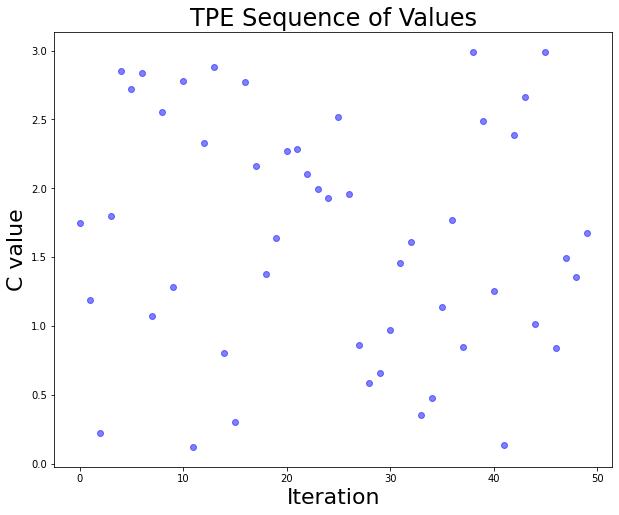

In [0]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['C'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('C value', size = 22); plt.title('TPE Sequence of Values', size = 24);

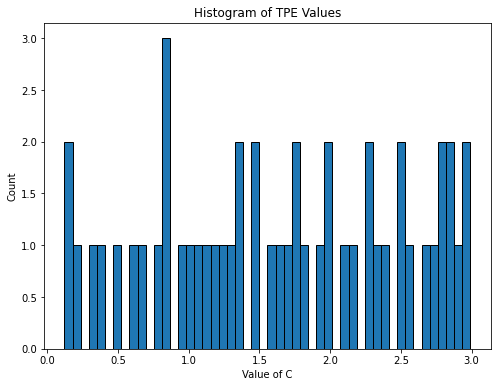

In [0]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['C'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of C'); plt.ylabel('Count');

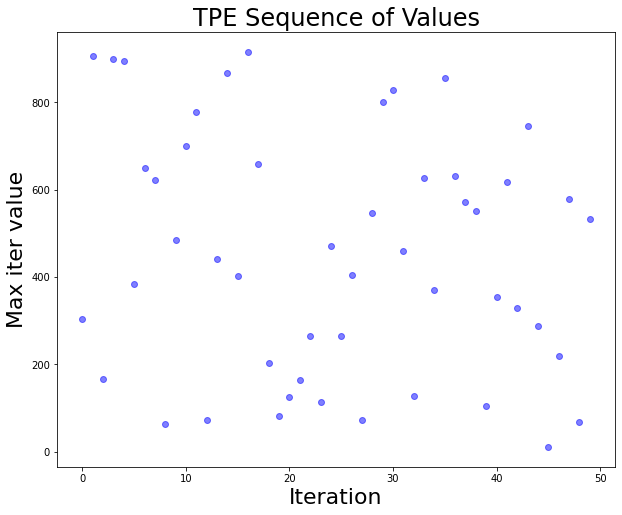

In [0]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['max_iter'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('Max iter value', size = 22); plt.title('TPE Sequence of Values', size = 24);

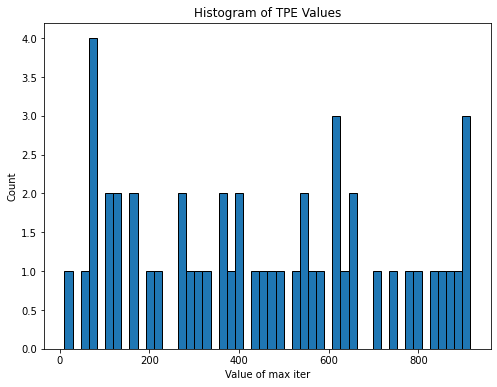

In [0]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['max_iter'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of max iter'); plt.ylabel('Count');

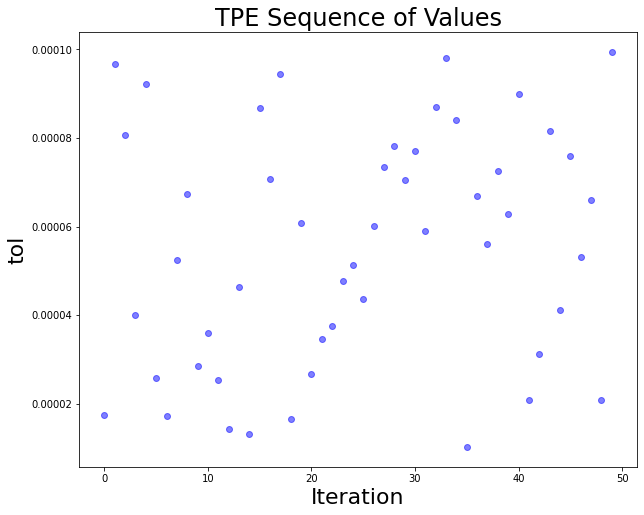

In [0]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['tol'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('tol', size = 22); plt.title('TPE Sequence of Values', size = 24);

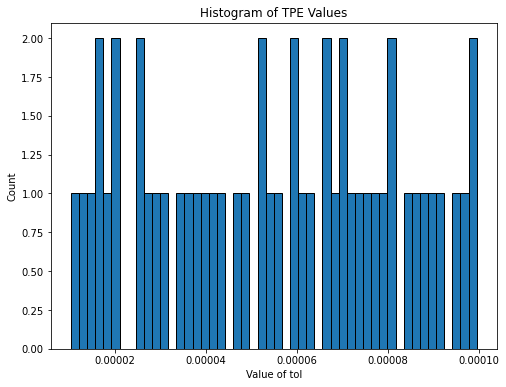

In [0]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['tol'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of tol'); plt.ylabel('Count');

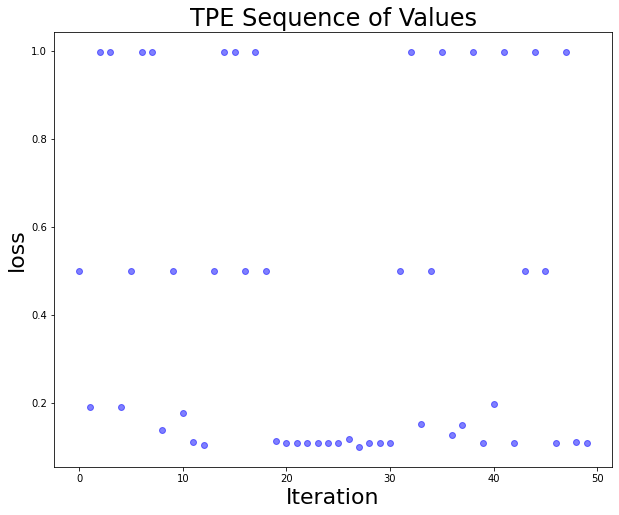

In [0]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['loss'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('loss', size = 22); plt.title('TPE Sequence of Values', size = 24);